### 💾💻📊 Data Science - MMI Portfolio No. 3
# 💥 Sentiment Analysis (NLP + Machine Learning) 💥



An extremely common dataset for benchmarking, method development, and tutorials is **MNIST** consisting of handwritten digits. In reference to this dataset several variants appeared such as sign-MNIST (photos of hand gestures for sign language), audioMNIST (audiofiles of spoken digits) and **fashionMNIST** made of low resolution photos of 10 types of clothes. We will here use this tp explore different possibilities for using dimensionality reduction techniques.

Please complete the following exercises:
## 1. Data Exploration and Cleaning
- Select equal number of reviews for all possible ratings (1 to 5).
- Use suitable Python libraries to detect the language for every restaurant review, for instance `langdetect`.
- Show a distribution of detected languages.
- Continue to work only with English entries.

Hint: This could take a little while, so better use `tqdm` or similar to show the progress.

## 2. TF-IDF + Logistic Regression vs Linear Regression
- Use the `TfidfVectorizer` to create vectors of all remaining reviews.
- Train a Logistic Regression model on the 5 rating classes
- Train a Linear Regression model on the rating (1 to 5).
- Compare both models, which works better?
- Also compare single tokens vs. 1 + 2-grams (`ngrams = (1,2)`), which works better.
- Show the 10 most relevant words (or ngrams) for predicting high or low ratings.

## 3. Language Model --> word vectors + Logistic Regression vs. Random Forest
- Use Spacy and a larger English language model (`spacy.load("en_core_web_lg")`) to create vectors for each review. This might take a while so use a progress bar.
- Train a Logistic Regression model as well as a RandomForestClassifier on the review embeddings to predict the 5 rating classes.
- Evaluate the performance of both models, and also compare to the TF-IDF case before.



## General instructions
- The final notebook should be executable in the correct order (this means it should work if you do `Kernel` --> `Restart kernel and run all cells...`)
- Just providing code and plots is not enough, you should document and comment where necessary. Not so much on small code-related things (you may still do this if you want though, but this is not required), but mostly to explain what you do, why you do it, what you observe.

More specifically:
- Please briefly comment on the changes you make to the data, in particular if you apply complex operations or if your changes depend on a certain choice you have to make.
- Please add descriptions and/or interpretations to the results you generate (for instance tables, plots). This doesn't have to be a lot of text. For simple, easy-to-understand results, a brief sentence can be enough. For more complex results, you might want to add a bit more explanation.

---
Please add your Name here
## Name: Kevin Zielke

---

## Imports and helper function
Use this part to import the main libraries used in this notebook.  
Also add more complex helper functions to this part (if you use any).

In [150]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from tqdm.notebook import tqdm

# add imports if anything is missing
# for instance. feel free to use other plotting libraries (e.g. seaborn, plotly...)

## Data download and import
The following analysis should be done with data from TripAdvisor, namely restraurant reviews from **Barcelona**. You can find the respective data (`Barcelona_reviews.csv`) on the [TripAdvisor data](https://zenodo.org/records/6583422).


In [151]:
path = os.path.join("..", "..", "Datasets", "Tripadvisor")
filename = os.path.join(path, "Barcelona_reviews.csv")
data = pd.read_csv(filename)
data = data.drop(["Unnamed: 0"], axis=1)
data.head()

C:\Users\kevin\AppData\Local\Temp\ipykernel_17692\1716722039.py:3: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)


,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,1,Chalito_Rambla,1,Negative,review_774086112,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve...","Ok, this place is terrible! Came here bc we’ve...","October 12, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
1,2,Chalito_Rambla,5,Positive,review_739142140,The best milanesa in central Barcelona,This place was a great surprise. The food is d...,This place was a great surprise. The food is d...,"January 14, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
2,3,Chalito_Rambla,5,Positive,review_749758638,Family bonding,The food is excellent.....the ambiance is very...,The food is excellent.....the ambiance is very...,"March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
3,4,Chalito_Rambla,5,Positive,review_749732001,Best food,"The food is execellent ,affortable price for p...","The food is execellent ,affortable price for p...","March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
4,5,Chalito_Rambla,5,Positive,review_749691057,Amazing Food and Fantastic Service,"Mr Suarez,The food at your restaurant was abso...","Mr Suarez,The food at your restaurant was abso...","March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


In [152]:
# Some cleaning
mask = data.rating_review == "Barcelona_Catalonia"
data = data[~mask]
data.rating_review = data.rating_review.astype(int)

## 1. Data Exploration and Cleaning

Hint: This could take a little while, so better use `tqdm` or similar to show the progress.

In [153]:
import tqdm as tqdm

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416355 entries, 0 to 416355
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   parse_count      416355 non-null  object
 1   restaurant_name  416355 non-null  object
 2   rating_review    416355 non-null  int32 
 3   sample           416355 non-null  object
 4   review_id        416355 non-null  object
 5   title_review     416355 non-null  object
 6   review_preview   416355 non-null  object
 7   review_full      416354 non-null  object
 8   date             416354 non-null  object
 9   city             416354 non-null  object
 10  url_restaurant   416354 non-null  object
 11  author_id        416354 non-null  object
dtypes: int32(1), object(11)
memory usage: 39.7+ MB


There is a single null value in the data. I will get rid of it, since a single missing entry wont affect the analysis.

In [155]:
data = data.dropna()

Exept for _rating_reviews_, all columns are strings. Some columns can be converted to proper data types that can be easier processed. _date_ for example can easily be converted to datime.

In [156]:
data.date = pd.to_datetime(data.date)

Every entry of _author_id_ contains "UID_" prefix. This can be removed and the column can be converted to integer.

In [157]:
data.author_id = data.author_id.str.removeprefix("UID_")
data.author_id = data.author_id.astype(int)

In [158]:
data.tail()

,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
416351,426639,Bodega_Biarritz,5,Positive,review_656474442,Awesome spot!,What a cute little hole in wall! The decorum w...,What a cute little hole in wall! The decorum w...,2019-03-04,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,232019
416352,426640,Bodega_Biarritz,5,Positive,review_656066564,Great tapas and great service,We really enjoyed the tapas here. Each of the...,We really enjoyed the tapas here. Each of the ...,2019-03-03,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,57970
416353,426641,Bodega_Biarritz,5,Positive,review_631216398,Fabulous Tapas,Tried to get a table at Bodega Biarritz 1820 b...,Tried to get a table at Bodega Biarritz 1820 b...,2018-11-06,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,36360
416354,426642,Bodega_Biarritz,5,Positive,review_630522900,Fantastic!,It was our first time eating tapas and it was ...,It was our first time eating tapas and it was ...,2018-11-03,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,18363
416355,426643,Bodega_Biarritz,5,Positive,review_630287967,Great experience,We went early (6.00pm) to avoid queuing as we ...,We went early (6.00pm) to avoid queuing as we ...,2018-11-02,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,40467


In [159]:
data.review_id.value_counts()

review_id
review_774086112    1
review_495623401    1
review_500779404    1
review_500845386    1
review_501058790    1
                   ..
review_582017693    1
review_584876128    1
review_475586397    1
review_476139753    1
review_630287967    1
Name: count, Length: 416354, dtype: int64

By looking at data.head() and data.tail() it looks like the column _parse_count_ is just a messed up ID column. There is also _review_id_, which is another ID column. I will drop them both, because it clutters the output and I will just use the dataframe indexing.

In [160]:
data.drop(["parse_count", "review_id"], axis=1, inplace=True)

The _sample_ column only contains the entries positive and negative. We can turn this into a boolean column, where positive is TRUE and negative is FALSE.

In [161]:
data["sample"].value_counts()

sample
Positive    338778
Negative     77576
Name: count, dtype: int64

In [162]:
positive_mask = data["sample"] == "Positive"
negative_mask = data["sample"] == "Negative"

data.loc[positive_mask, "sample"] = 1
data.loc[negative_mask, "sample"] = 0

data["sample"] = data["sample"].astype(bool)

Finally I like to code data.sample more than data["sample"]. I will rename the _sample_ column to _bias_ so that python does not mistake this writing for the dataframe method sample(). Also i like short column names in general, so I will rename some of them. 

In [163]:
data = data.rename(columns={"sample": "bias",
                            "restaurant_name": "restaurant",
                            "rating_review": "rating",
                            "title_review": "title",
                            "review_preview": "preview",
                            "review_full": "full" })

In [164]:
data.head()

,restaurant,rating,bias,title,preview,full,date,city,url_restaurant,author_id
0,Chalito_Rambla,1,False,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve...","Ok, this place is terrible! Came here bc we’ve...",2020-10-12,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,0
1,Chalito_Rambla,5,True,The best milanesa in central Barcelona,This place was a great surprise. The food is d...,This place was a great surprise. The food is d...,2020-01-14,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,1
2,Chalito_Rambla,5,True,Family bonding,The food is excellent.....the ambiance is very...,The food is excellent.....the ambiance is very...,2020-03-07,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,2
3,Chalito_Rambla,5,True,Best food,"The food is execellent ,affortable price for p...","The food is execellent ,affortable price for p...",2020-03-07,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,3
4,Chalito_Rambla,5,True,Amazing Food and Fantastic Service,"Mr Suarez,The food at your restaurant was abso...","Mr Suarez,The food at your restaurant was abso...",2020-03-07,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,4


Now the full dataframe fits my screen and every column has the best possible dtype.

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416354 entries, 0 to 416355
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   restaurant      416354 non-null  object        
 1   rating          416354 non-null  int32         
 2   bias            416354 non-null  bool          
 3   title           416354 non-null  object        
 4   preview         416354 non-null  object        
 5   full            416354 non-null  object        
 6   date            416354 non-null  datetime64[ns]
 7   city            416354 non-null  object        
 8   url_restaurant  416354 non-null  object        
 9   author_id       416354 non-null  int32         
dtypes: bool(1), datetime64[ns](1), int32(2), object(6)
memory usage: 29.0+ MB


### 1.1 - Select equal number of reviews for all possible ratings (1 to 5).

2 is the least frequently given rating with 18178 entries. I will select 18178 random reviews for each rating. 

In [166]:
data.rating.value_counts()

rating
5    241976
4     96802
3     33148
1     26250
2     18178
Name: count, dtype: int64

In [167]:
samples = data.rating.value_counts().min()
data = data.groupby('rating').apply(lambda x: x.sample(n=samples))
data.rating.value_counts()

C:\Users\kevin\AppData\Local\Temp\ipykernel_17692\3631636527.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('rating').apply(lambda x: x.sample(n=samples))


rating
1    18178
2    18178
3    18178
4    18178
5    18178
Name: count, dtype: int64

### 1.2 - Use suitable Python libraries to detect the language for every restaurant review, for instance `langdetect`.

I will create a new column _language_ and fill it with the detected language of the review. I will use the _preview_ of the review to detect the language, because it is processed faster than the whole review and has a sufficient amount of words to detect the language. I will also enable tqdm for the pandas.apply() function (and use progress_apply() instead), so that I can see the progress.

In [168]:
!pip install langdetect

In [169]:
from langdetect import detect
from tqdm.auto import tqdm

tqdm.pandas()

In [170]:
filepath = os.path.join(path, "Barcelona_reviews_cleaned.csv")

try:
    data = pd.read_csv(filepath)
    print(f"Loaded detected languages from {filepath}")
except:
    print(f"Found no data at {filepath}. Detecting Languages:")

    data["language"] = data.preview.progress_apply(detect)
    data.to_csv(filepath, index=False)

data.head()

Loaded detected languages from ..\..\Datasets\Tripadvisor\Barcelona_reviews_cleaned.csv


,restaurant,rating,bias,title,preview,full,date,city,url_restaurant,author_id,language
0,Nineteen_Restaurant,1,False,4.50€ For a glass of sparkling water,"Being from Barcelona, stop a minute to wait fo...","Being from Barcelona, stop a minute to wait fo...",2016-07-24,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,54770,en
1,El_Pi_Antic,1,False,Avoid - poor quality and overpriced,Stumbled upon this place after a long days wor...,Stumbled upon this place after a long days wor...,2015-06-09,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,217874,en
2,Restaurant_El_Beso_y_La_Lluna,1,False,One of the worst.,Sometimes a restaurant experience is so bad yo...,Sometimes a restaurant experience is so bad yo...,2017-07-23,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,197546,en
3,Casa_Guinart,1,False,not so good tapas,I am sorry to say but hit restaurant was very ...,I am sorry to say but hit restaurant was very ...,2019-05-28,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,166297,en
4,Bravo,1,False,Overpriced trap!!,"Was at Bravo during Mobile World Congress, I h...","Was at Bravo during Mobile World Congress, I h...",2016-03-02,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,182238,en


### 1.3 - Show a distribution of detected languages.

Pie plots are well suited to show the distribution of categorical data. We can see that nearly all reviews are in english.

<Axes: ylabel='count'>

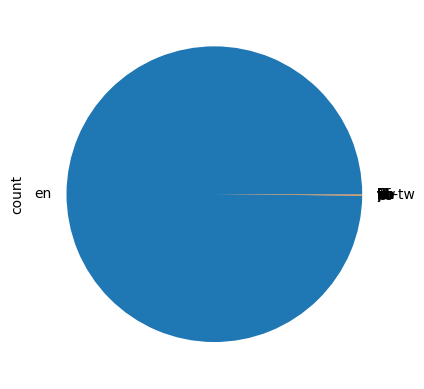

In [171]:
data.language.value_counts().plot(kind="pie")

### 1.4 - Continue to work only with English entries.

In [172]:
english_mask = data.language == "en"
data_cleaned = data[english_mask]

Our ratings were perfectly balanced because we selected the same amount of reviews for each rating in 1.1. After filtering out non-english reviews, the ratings are not perfectly balanced anymore, but as we can see in the pie plots, there were very few non-english reviews and the ratings are still very balanced.

<Axes: ylabel='count'>

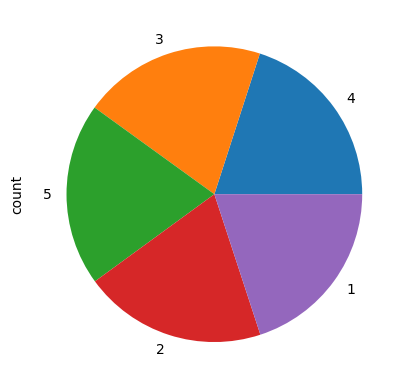

In [173]:
data_cleaned.rating.value_counts().plot(kind="pie")

## 2. TF-IDF + Logistic Regression vs Linear Regression

### 2.1 - Use the `TfidfVectorizer` to create vectors of all remaining reviews.

The vectorizer transforms the words of a review into tokens and then converts these tokens to a bunch of numerical vectors. These vectors are essentially just a long list of zeros representing every word in the corpus of the training data. With a single 1 indicating the actual word. This step is called One-Hot-Encoding. Using these numerical vectors opens up many possibilities to compare them using different algebraic methods.
It is important to fit the vectorizer only on the training data to prevent data leakage. There will be some tokens in the test data, that are out of vocabulary of the model, but this is just what would happen in the real world too.

In [174]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_cleaned.full, data_cleaned.rating, test_size=0.2, random_state=42)

In [175]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.25)
vectors_train = vectorizer.fit_transform(X_train)

### 2.2 - Train a Logistic Regression model on the 5 rating classes

Although it is called logistic regression, it is still a classification method. The 5 levels of the ratings are an ordinal scale, which has a hierarchical context (5>4>3>2>1), but can be interpreted as just 5 categories too. 

In [176]:
# Train a Logistic Regression model on the 5 rating classes
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(vectors_train, y_train)

LogisticRegression(max_iter=1000)

### 2.3 - Train a Linear Regression model on the rating (1 to 5).

Linear Regression is an actual regression and works with continous values. This way the ordered context of the ratings is kept, but it will also predict impossible ratings like 4.5 or even something out of the scale like 11. 

In [177]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
linear_regression.fit(vectors_train, y_train)

LinearRegression()

### 2.4 - Compare both models, which works better?

In [178]:
import random

vectors_test = vectorizer.transform(X_test)

logistic_pred = logistic_regression.predict(vectors_test)
linear_pred = linear_regression.predict(vectors_test)
random_pred = [random.randint(1, 5) for _ in range(vectors_test.shape[0])]
all_5s_pred = [5] * vectors_test.shape[0]

In [179]:
def plot_ditribution_and_errors(y_test, pred, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
    fig.suptitle(title)
    
    ax1.hist(y_test, bins=100, rwidth=0.6)
    ax1.set_title("Ground truth distribution")

    ax2.hist(pred, bins=100, rwidth=0.6)
    ax2.set_title("Prediction distribution")

    ax3.hist(y_test - pred, bins=100, rwidth=0.6)
    ax3.set_title("Prediction errors")

    plt.tight_layout()
    plt.show()

In [180]:
def mean_absolute_error(y_test, y_pred):
    return np.abs(y_pred - y_test).mean()

We will use mean absolute error (MAE) and mean squarred error (MSE) as metrics to evaluate our models. We will later analyze why MSE is not a good metric for this task. To get a better understanding of what good and bad values are for this problem, we will first calculate them for random predictions and for predictions that always rate 5.

In [181]:
print("Random predictions MAE: ", mean_absolute_error(random_pred, y_test))
print("Random predictions MSE: ", mean_squared_error(random_pred, y_test))

print("\nAll 5s predictions MAE: ", mean_absolute_error(all_5s_pred, y_test))
print("All 5s predictions MAE: ", mean_squared_error(all_5s_pred, y_test))

Random predictions MAE:  1.585752851082585
Random predictions MSE:  3.937358823205333

All 5s predictions MAE:  2.013277505371605
All 5s predictions MAE:  6.018897030466641


In [182]:
from sklearn.metrics import classification_report

print(classification_report(y_test, random_pred))
print(classification_report(y_test, all_5s_pred))

              precision    recall  f1-score   support

           1       0.19      0.19      0.19      3579
           2       0.21      0.21      0.21      3713
           3       0.20      0.20      0.20      3740
           4       0.20      0.20      0.20      3608
           5       0.19      0.19      0.19      3511

    accuracy                           0.20     18151
   macro avg       0.20      0.20      0.20     18151
weighted avg       0.20      0.20      0.20     18151

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3579
           2       0.00      0.00      0.00      3713
           3       0.00      0.00      0.00      3740
           4       0.00      0.00      0.00      3608
           5       0.19      1.00      0.32      3511

    accuracy                           0.19     18151
   macro avg       0.04      0.20      0.06     18151
weighted avg       0.04      0.19      0.06     18151



c:\Users\kevin\miniconda3\envs\data_science\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\miniconda3\envs\data_science\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\miniconda3\envs\data_science\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [183]:
conclusion_df = pd.DataFrame(columns=["name", "MAE", "MSE", "accuracy"], data=[["random", 1.598, 3.982, 0.2], ["all 5s", 2.013, 6.019, 0.19]])
conclusion_df

,name,MAE,MSE,accuracy
0,random,1.598,3.982,0.20
1,all 5s,2.013,6.019,0.19


#### 2.4.1 - Linear Regression Evaluation

As expected the linear regression will output continuous values instead of integers but also impossible values, such as negative values or values outside the rating range.
The prediction errors have a gaussian distribution around 0, which means that most of the predictions are close to the actual rating, which is good. It also looks like most predictions are not a lot farther off the actual rating as 2.  
The MAE and MSE are both far better than the random and all 5 predictions, which shows that the model does the job well.

Linear Regression: mean absolute error:  0.630211309404829
Linear Regression: mean squared error:  0.6298001910821002


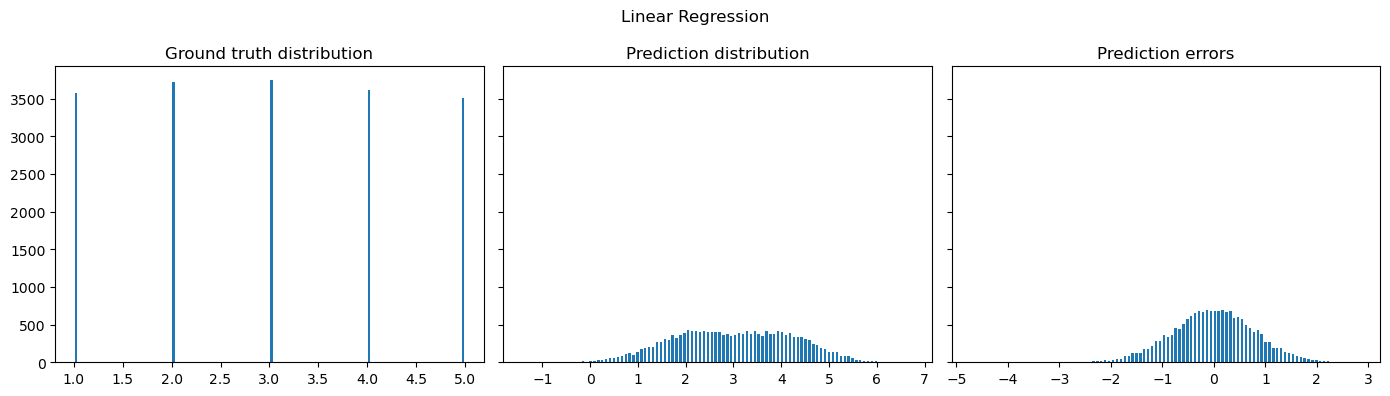

In [184]:
print("Linear Regression: mean absolute error: ", mean_absolute_error(y_test, linear_pred))
print("Linear Regression: mean squared error: ", mean_squared_error(y_test, linear_pred))
plot_ditribution_and_errors(y_test, linear_pred, "Linear Regression")

In [185]:
new_entry = pd.DataFrame({
    'name': ['linear regression'],
    'MAE': [0.630],
    'MSE': [0.630]
})
conclusion_df = pd.concat([conclusion_df, new_entry], ignore_index=True)
conclusion_df


,name,MAE,MSE,accuracy
0,random,1.598,3.982,0.20
1,all 5s,2.013,6.019,0.19
2,linear regression,0.630,0.630,NaN


In [186]:
pd.Series(linear_pred).describe()

count    18151.000000
mean         2.998477
std          1.231985
min         -1.423610
25%          2.065710
50%          3.003868
75%          3.963730
max          6.759410
dtype: float64

Since there cant be any ratings higher than 5 or lower than 1, we can simply clip every prediction outside that range. Everything bigger than 5 will just be rated as 5 and everything lower than 1 as 1. We can see that this lead to peaks in the distribution at the values 1 and 5. But also to a high peak in the prediction errors at 0, which is very good, because prediction error 0 means that the prediction is spot on. There are also some visible peaks in the prediction errors at 1 and -1. These are all the 2 and 4 star ratings that were predicted as something outside the range. They are still not correctly predicted, but they got closer to the actual rating. This might have also happened for some 3 star ratings, but there is no peak visible. This makes sense, because we could see in the prediction error distribution from before, that there are very few ratings off by 2 overall.  
By clipping the MAE sunk from .63 to .595 and the MSE sunk from .63 to .597 which is good.

Linear Regression (clipped): mean absolute error:  0.5950743099828714
Linear Regression (clipped): mean squared error:  0.5967809117567737


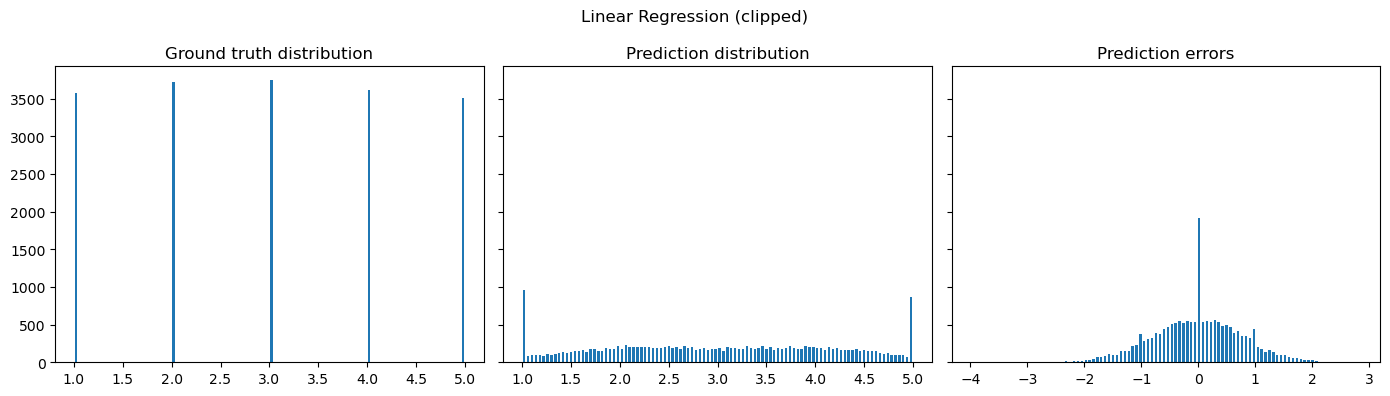

In [187]:
linear_pred_clipped = np.clip(linear_pred, 1, 5)

print("Linear Regression (clipped): mean absolute error: ", mean_absolute_error(y_test, linear_pred_clipped))
print("Linear Regression (clipped): mean squared error: ", mean_squared_error(y_test, linear_pred_clipped))

plot_ditribution_and_errors(y_test, linear_pred_clipped, "Linear Regression (clipped)")

Lastly I will get rid of the continuous nature of the predictitions by rounding them to integers. This way I can directly compare the predictions of the linear regression model to the logistic regression predicitons. Interestingly the MSE rose to .684 (even more than before clipping) when I rounded the values, while the MAE sunk even further to .558. This happens because when the rounded predictions are off, they are no longer off for just some small value <1, but always at least 1 off. The squared nature of MSE penalizes this a lot more. This is why I will look at the MAE for evaluation, because it is a more intuitive metric in this case.

Linear Regression (clipped & rounded): mean absolute error:  0.5578755991405432
Linear Regression (clipped & rounded): mean squared error:  0.6847005674618478


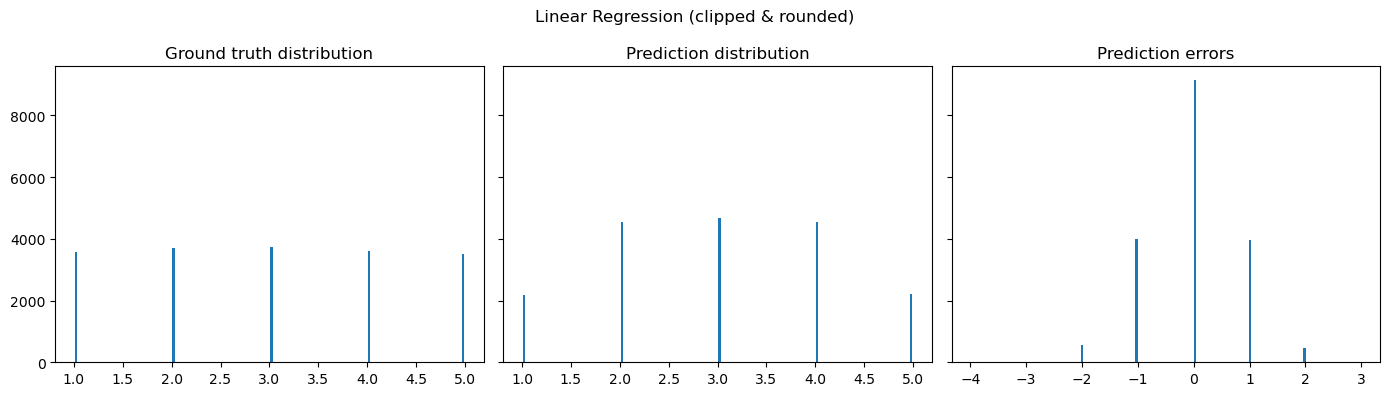

In [188]:
linear_pred_clipped_and_rounded = np.round(linear_pred_clipped)

print("Linear Regression (clipped & rounded): mean absolute error: ", mean_absolute_error(y_test, linear_pred_clipped_and_rounded))
print("Linear Regression (clipped & rounded): mean squared error: ", mean_squared_error(y_test, linear_pred_clipped_and_rounded))

plot_ditribution_and_errors(y_test, linear_pred_clipped_and_rounded, "Linear Regression (clipped & rounded)")

#### 2.4.2 - Logisitic Regression Evaluation

The confusion matrix for the logistic regression model shows good results. Especially the 1 and 5 ratings are predicted nicely. The classification report shows that these ratings also have high accuracy scores of 0.67 and 0.68. Even though there are more reviews for the other ratings, the 1 and 5 ratings score better. This might be, because these ratings are more likely to use expressive vocabulary, which can be easily predicted.

              precision    recall  f1-score   support

           1       0.67      0.72      0.70      3579
           2       0.51      0.47      0.49      3713
           3       0.55      0.53      0.54      3740
           4       0.54      0.54      0.54      3608
           5       0.68      0.71      0.70      3511

    accuracy                           0.59     18151
   macro avg       0.59      0.59      0.59     18151
weighted avg       0.59      0.59      0.59     18151



<Axes: title={'center': 'Logistic Regression Confusion Matrix'}>

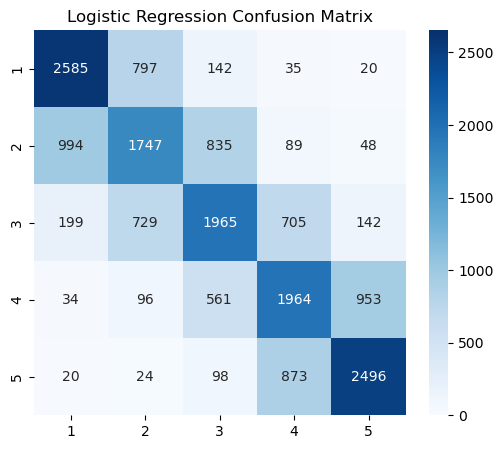

In [189]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, logistic_pred))

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.set_title("Logistic Regression Confusion Matrix")
sb.heatmap(confusion_matrix(y_test, logistic_pred),
           annot=True, cmap='Blues', fmt="g", 
           xticklabels=logistic_regression.classes_,
           yticklabels=logistic_regression.classes_,
           vmin=0, vmax=2653)

#### 2.4.3 - Direct Comparison

For direct comparison I use the evaluation method for each model on the other model. The classification report of the linear regression shows overall worse results than the logistic regression one. But the precision scores for the 1 and 5 ratings are noteably higher.  
The confusion matrix of the lienar regression also shows that it is less accurate than the logistic regression one.

              precision    recall  f1-score   support

           1       0.71      0.43      0.53      3579
           2       0.43      0.53      0.48      3713
           3       0.42      0.53      0.47      3740
           4       0.45      0.57      0.51      3608
           5       0.71      0.45      0.55      3511

    accuracy                           0.50     18151
   macro avg       0.55      0.50      0.51     18151
weighted avg       0.54      0.50      0.51     18151



<Axes: title={'center': 'Linear Regression (clipped & rounded) Confusion Matrix'}>

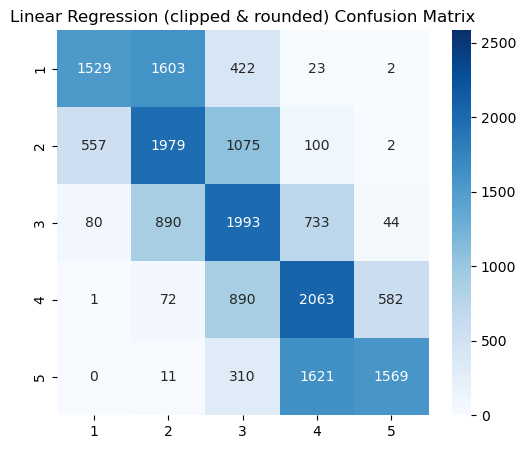

In [190]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, linear_pred_clipped_and_rounded))

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.set_title("Linear Regression (clipped & rounded) Confusion Matrix")
sb.heatmap(confusion_matrix(y_test, linear_pred_clipped_and_rounded),
           annot=True, cmap='Blues', fmt="g", 
           xticklabels=logistic_regression.classes_,
           yticklabels=logistic_regression.classes_,
           vmin=0, vmax=2585)

Logistic Regression: mean absolute error:  0.47170954768332324
Logistic Regression: mean squared error:  0.629166437110903


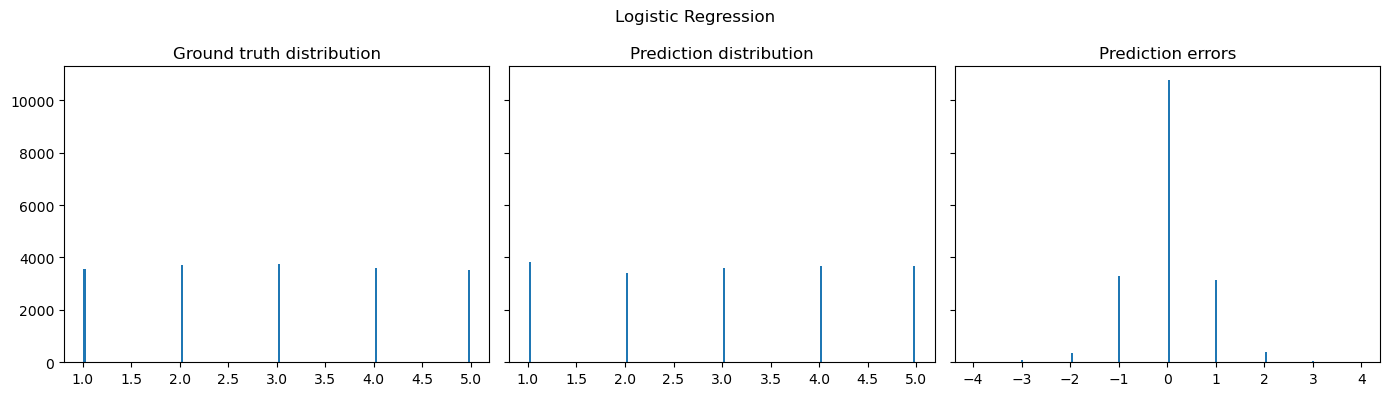

In [191]:
print("Logistic Regression: mean absolute error: ", mean_absolute_error(y_test, logistic_pred))
print("Logistic Regression: mean squared error: ", mean_squared_error(y_test, logistic_pred))
plot_ditribution_and_errors(y_test, logistic_pred, "Logistic Regression")

In [192]:
print("mean squared error: ")
print("Linear Regression: ", mean_squared_error(y_test, linear_pred))
print("Linear Regression clipped and rounded: ", mean_squared_error(y_test, linear_pred_clipped_and_rounded))
print("Logistic Regression: ", mean_squared_error(y_test, logistic_pred))
print("\nmean absolute error: ")
print("Linear Regression: ", np.abs(linear_pred - y_test).mean())
print("Linear Regression clipped and rounded: ", np.abs(linear_pred_clipped_and_rounded - y_test).mean())
print("Logistic Regression: ", np.abs(logistic_pred - y_test).mean())

mean squared error: 
Linear Regression:  0.6298001910821002
Linear Regression clipped and rounded:  0.6847005674618478
Logistic Regression:  0.629166437110903

mean absolute error: 
Linear Regression:  0.630211309404829
Linear Regression clipped and rounded:  0.5578755991405432
Logistic Regression:  0.47170954768332324


The MAE and MSE results also show that the logistic regression model performs better than the linear regression model. Altough there is alsmost no difference in MSE for linear (without clipping and rounding) and logistic regression, i have already established why this metric is not as suitable as MAE.  
For MAE we see that logistic regression outperforms the linear models clearly.

In [193]:
new_entry1 = pd.DataFrame({
    'name': ['logistic regression'],
    'MAE': [0.471],
    'MSE': [0.629],
    'accuracy': [0.59]
})

new_entry2 = pd.DataFrame({
    'name': ['linear regression (clipped & rounded)'],
    'MAE': [0.558],
    'MSE': [0.685],
    'accuracy': [0.50]
})
conclusion_df = pd.concat([conclusion_df, new_entry1, new_entry2], ignore_index=True)
conclusion_df

,name,MAE,MSE,accuracy
0,random,1.598,3.982,0.20
1,all 5s,2.013,6.019,0.19
2,linear regression,0.630,0.630,NaN
3,logistic regression,0.471,0.629,0.59
4,linear regression (clipped & rounded),0.558,0.685,0.50


### 2.5 - Also compare single tokens vs. 1 + 2-grams (`ngrams = (1,2)`), which works better.

In [194]:
from scipy.sparse import load_npz, save_npz
import joblib

filepath_train = os.path.join(path, "reviews_ngram_vectors_train.npz")
filepath_test = os.path.join(path, "reviews_ngram_vectors_test.npz")
vectorizer_filepath = os.path.join(path, "ngram_vectorizer.pkl")

try:
    ngram_vectors_train = load_npz(filepath_train)
    print(f"Loaded ngram_vectors_train from {filepath_train}")

    ngram_vectors_test = load_npz(filepath_test)
    print(f"Loaded ngram_vectors_test from {filepath_test}")

    ngram_vectorizer = joblib.load(vectorizer_filepath)
    print(f"Loaded ngram_vectorizer from {vectorizer_filepath}")

except:
    print(f"Found no vectors at {path}. Calculating...")
    ngram_vectorizer = TfidfVectorizer(min_df=10, max_df=0.25,
                                    ngram_range=(1, 2))
    # fit the vectorizer on the training data and transform the training data
    ngram_vectors_train = ngram_vectorizer.fit_transform(X_train)

    # save vectors and fitted vectorizer
    save_npz(filepath_train, ngram_vectors_train)
    print(f"Saved ngram_vectors_train to {filepath_train}")
    joblib.dump(ngram_vectorizer, vectorizer_filepath)
    print(f"Saved ngram_vectorizer to {vectorizer_filepath}")

    # transform the test data
    ngram_vectors_test = ngram_vectorizer.transform(X_test)
    save_npz(filepath_test, ngram_vectors_test)
    print(f"Saved ngram_vectors_test to {filepath_test}")

Loaded ngram_vectors_train from ..\..\Datasets\Tripadvisor\reviews_ngram_vectors_train.npz
Loaded ngram_vectors_test from ..\..\Datasets\Tripadvisor\reviews_ngram_vectors_test.npz
Loaded ngram_vectorizer from ..\..\Datasets\Tripadvisor\ngram_vectorizer.pkl


In [195]:
import joblib

filepath = os.path.join(path, "logistic_regression_ngrams.pkl")

try:
    with open(filepath, 'rb') as file:
        logistic_regression_spacy = joblib.load(filepath)
    
    print(f"Loaded logistic_regression_ngrams from {filepath}")

except:
    print(f"Found nothing at {filepath}. Calculating...")
    logistic_regression_spacy = LogisticRegression(max_iter=1000)
    logistic_regression_spacy.fit(ngram_vectors_train, y_train)
    
    joblib.dump(logistic_regression_spacy, filepath)
    print(f"Saved logistic_regression_ngrams to {filepath}")

Loaded logistic_regression_ngrams from ..\..\Datasets\Tripadvisor\logistic_regression_ngrams.pkl


In [196]:
import joblib

filepath = os.path.join(path, "linear_regression_ngrams.pkl")

try:
    with open(filepath, 'rb') as file:
        linear_regression_ngrams = joblib.load(filepath)
    
    print(f"Loaded linear_regression_ngrams from {filepath}")

except:
    print(f"Found nothing at {filepath}. Calculating...")
    linear_regression_ngrams = LinearRegression()
    linear_regression_ngrams.fit(ngram_vectors_train, y_train)
    
    joblib.dump(linear_regression_ngrams, filepath)
    print(f"Saved linear_regression_ngrams to {filepath}")

Loaded linear_regression_ngrams from ..\..\Datasets\Tripadvisor\linear_regression_ngrams.pkl


In [197]:
ngram_vectors_test = ngram_vectorizer.transform(X_test)

logistic_ngram_pred = logistic_regression_spacy.predict(ngram_vectors_test)
linear_ngram_pred = linear_regression_ngrams.predict(ngram_vectors_test)

Linear regression with 1- and 2-grams: mean absolute error:  3.0643008788289596


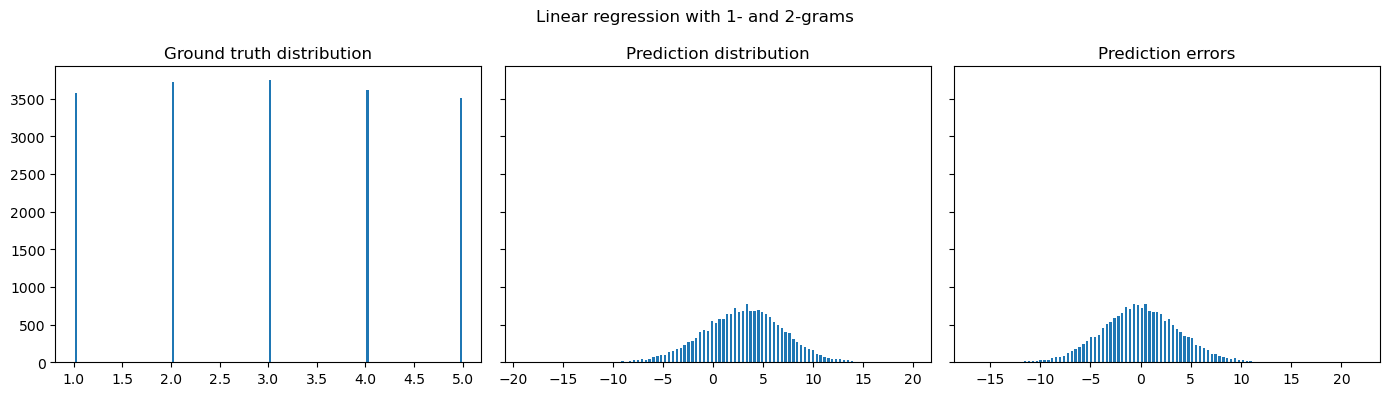

In [198]:
print("Linear regression with 1- and 2-grams: mean absolute error: ", mean_absolute_error(y_test, linear_ngram_pred))
plot_ditribution_and_errors(y_test, linear_ngram_pred, "Linear regression with 1- and 2-grams")

Linear regression with 1- and 2-grams (clipped): mean absolute error:  1.4777018677872518


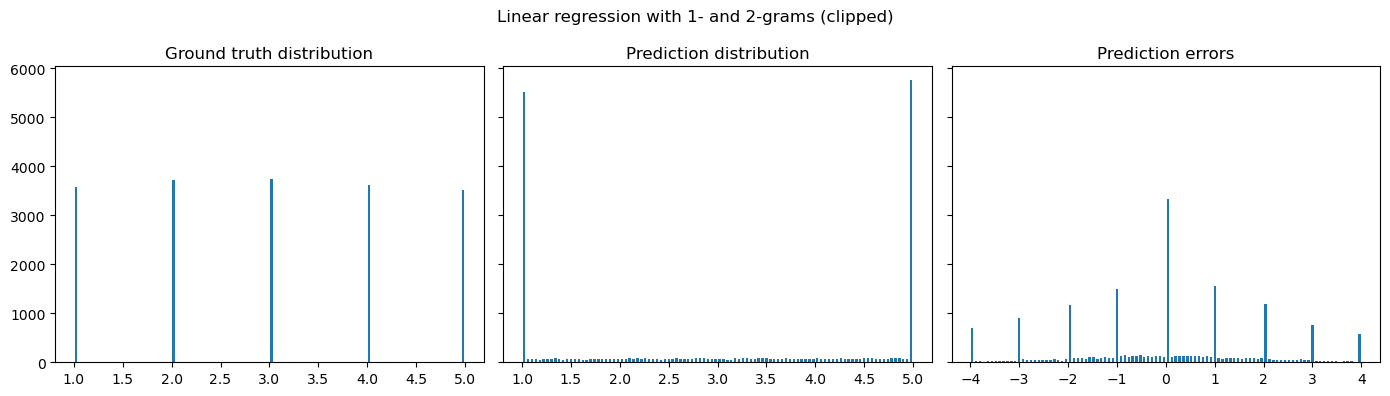

In [199]:
linear_ngram_pred_clipped = np.clip(linear_ngram_pred, 1, 5)

print("Linear regression with 1- and 2-grams (clipped): mean absolute error: ", mean_absolute_error(y_test, linear_ngram_pred_clipped))
plot_ditribution_and_errors(y_test, linear_ngram_pred_clipped, "Linear regression with 1- and 2-grams (clipped)")

In [200]:
print(pd.Series(linear_ngram_pred).describe())
print(pd.Series(linear_ngram_pred_clipped).describe())

count    18151.000000
mean         3.019071
std          4.036301
min        -18.988540
25%          0.383644
50%          3.127576
75%          5.729833
max         19.910743
dtype: float64
count    18151.000000
mean         3.040836
std          1.719084
min          1.000000
25%          1.000000
50%          3.127576
75%          5.000000
max          5.000000
dtype: float64


Linear regression with 1- and 2-grams (clipped & rounded): mean absolute error:  1.4771086992452207


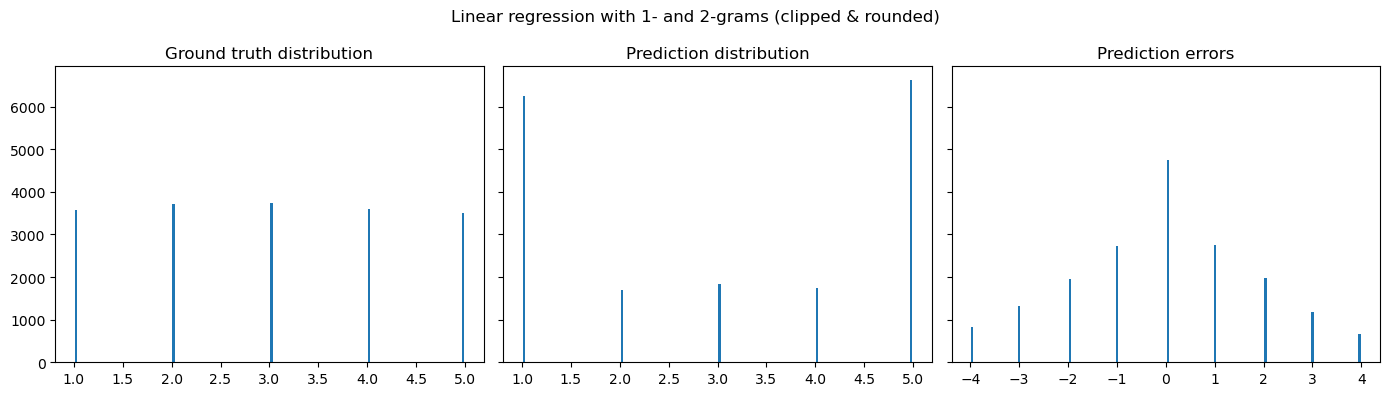

In [201]:
linear_ngram_pred_clipped_and_rounded = np.round(linear_ngram_pred_clipped)

print("Linear regression with 1- and 2-grams (clipped & rounded): mean absolute error: ", mean_absolute_error(y_test, linear_ngram_pred_clipped_and_rounded))
plot_ditribution_and_errors(y_test, linear_ngram_pred_clipped_and_rounded, "Linear regression with 1- and 2-grams (clipped & rounded)")

              precision    recall  f1-score   support

           1       0.28      0.50      0.36      3579
           2       0.20      0.09      0.13      3713
           3       0.22      0.11      0.14      3740
           4       0.22      0.11      0.15      3608
           5       0.28      0.52      0.36      3511

    accuracy                           0.26     18151
   macro avg       0.24      0.27      0.23     18151
weighted avg       0.24      0.26      0.23     18151



<Axes: title={'center': 'Linear Regression (clipped & rounded) with 1- & 2-grams:\n Confusion Matrix'}>

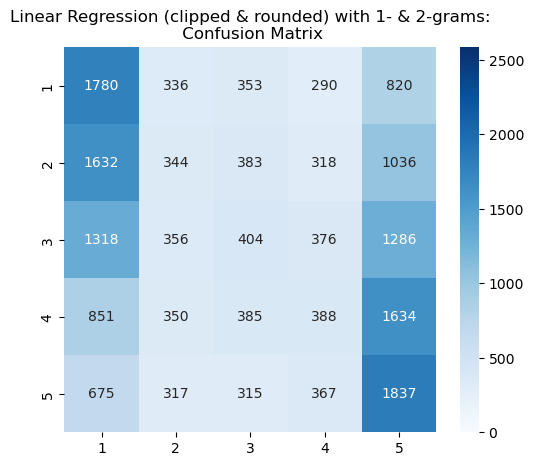

In [202]:
print(classification_report(y_test, linear_ngram_pred_clipped_and_rounded))

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.set_title("Linear Regression (clipped & rounded) with 1- & 2-grams:\n Confusion Matrix")
sb.heatmap(confusion_matrix(y_test, linear_ngram_pred_clipped_and_rounded),
           annot=True, cmap='Blues', fmt="g", 
           xticklabels=logistic_regression_spacy.classes_,
           yticklabels=logistic_regression_spacy.classes_,
           vmin=0, vmax=2585)

              precision    recall  f1-score   support

           1       0.69      0.74      0.71      3579
           2       0.53      0.50      0.51      3713
           3       0.59      0.56      0.57      3740
           4       0.58      0.57      0.58      3608
           5       0.70      0.74      0.72      3511

    accuracy                           0.62     18151
   macro avg       0.62      0.62      0.62     18151
weighted avg       0.62      0.62      0.62     18151



<Axes: title={'center': 'Logistic regression with 1- & 2-grams: Confusion Matrix'}>

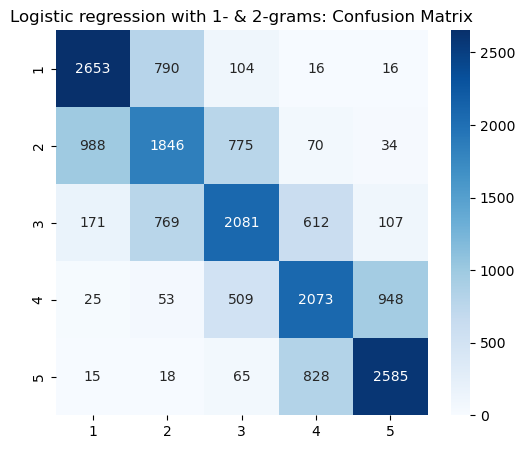

In [203]:
print(classification_report(y_test, logistic_ngram_pred))

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.set_title("Logistic regression with 1- & 2-grams: Confusion Matrix")
sb.heatmap(confusion_matrix(y_test, logistic_ngram_pred),
           annot=True, cmap='Blues', fmt="g", 
           xticklabels=logistic_regression_spacy.classes_,
           yticklabels=logistic_regression_spacy.classes_,
           vmin=0, vmax=2653)

Logitsic Regression with 1- and 2-grams: mean absolute error:  0.42763484105558924


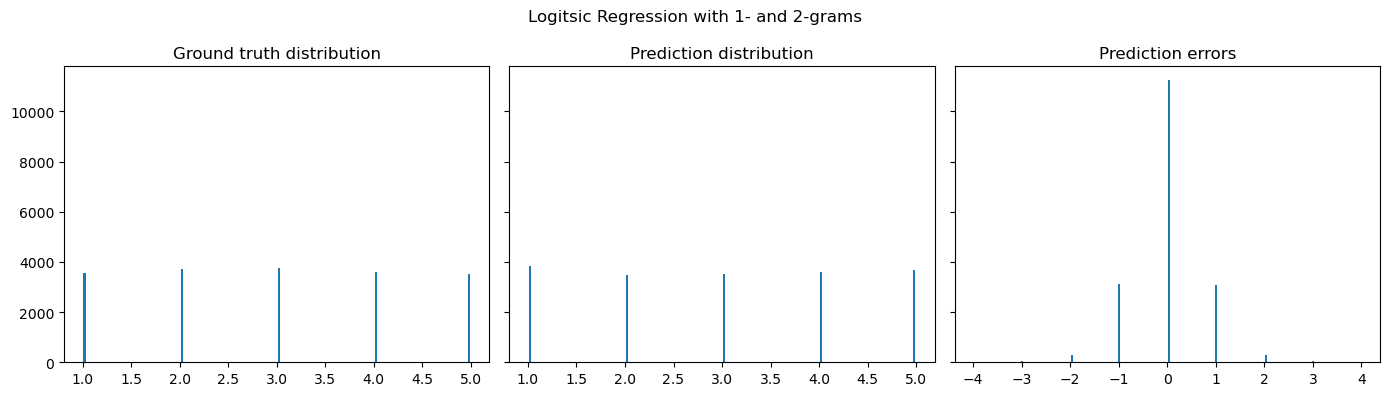

In [204]:
print("Logitsic Regression with 1- and 2-grams: mean absolute error: ", mean_absolute_error(y_test, logistic_ngram_pred))
plot_ditribution_and_errors(y_test, logistic_ngram_pred, "Logitsic Regression with 1- and 2-grams")

In [205]:
print("mean squared error: ")
print("Linear Regression: ", mean_squared_error(y_test, linear_ngram_pred))
print("Linear Regression clipped and rounded: ", mean_squared_error(y_test, linear_ngram_pred_clipped_and_rounded))
print("Logistic Regression: ", mean_squared_error(y_test, logistic_ngram_pred))
print("\nmean absolute error: ")
print("Linear Regression: ", np.abs(linear_ngram_pred - y_test).mean())
print("Linear Regression clipped and rounded: ", np.abs(linear_ngram_pred_clipped_and_rounded - y_test).mean())
print("Logistic Regression: ", np.abs(logistic_ngram_pred - y_test).mean())

mean squared error: 
Linear Regression:  15.085314520743655
Linear Regression clipped and rounded:  3.7240372431271003
Logistic Regression:  0.541678144454851

mean absolute error: 
Linear Regression:  3.0643008788289596
Linear Regression clipped and rounded:  1.4771086992452207
Logistic Regression:  0.42763484105558924


The linear regression model performs very bad with ngram input. It is even worse than randomly guessing the ratings (MAE: 1.598) or just rating everything 5 (MAE: 2).  
The predictions range from -19 to +19.9 and a lot of the information is lost when they are clipped. 
But the logistic regression works even better with ngrams than with tokens lowering the MAE from 0.47 to 0.42.

In [206]:
new_entry1 = pd.DataFrame({
    'name': ['logistic regression ngrams'],
    'MAE': [0.428],
    'MSE': [0.542],
    'accuracy': [0.62]
})

new_entry2 = pd.DataFrame({
    'name': ['linear regression ngrams'],
    'MAE': [1.477],
    'MSE': [3.724],
    'accuracy': [0.26]
})
conclusion_df = pd.concat([conclusion_df, new_entry1, new_entry2], ignore_index=True)
conclusion_df

,name,MAE,MSE,accuracy
0,random,1.598,3.982,0.20
1,all 5s,2.013,6.019,0.19
2,linear regression,0.630,0.630,NaN
3,logistic regression,0.471,0.629,0.59
4,linear regression (clipped & rounded),0.558,0.685,0.50
5,logistic regression ngrams,0.428,0.542,0.62
6,linear regression ngrams,1.477,3.724,0.26


### 2.6 - Show the 10 most relevant words (or ngrams) for predicting high or low ratings.

In [207]:
def show_most_relevant_words(model, rating, vectorizer, top_n_words=10):
    feature_names = np.array(vectorizer.get_feature_names_out())
    if(type(model) == LogisticRegression):
        coef = model.coef_[rating - 1]
    else:
        coef = model.coef_
    top_n = np.argsort(coef)[-top_n_words:]
    return feature_names[top_n]

In [208]:
print("Most relevant words for Rating 1:")
print("Logistic Regression:\n", show_most_relevant_words(logistic_regression, 1, vectorizer))
print("Logistic Regression with 1- and 2-grams:\n", show_most_relevant_words(logistic_regression_spacy, 1, ngram_vectorizer))
print("Linear Regression:\n", show_most_relevant_words(linear_regression, 1, vectorizer))
print("Linear Regression with 1- and 2-grams:\n", show_most_relevant_words(linear_regression_ngrams, 1, ngram_vectorizer))

print("\nMost relevant words for Rating 5:")
print("Logistic Regression:\n", show_most_relevant_words(logistic_regression, 5, vectorizer))
print("Logistic Regression with 1- and 2-grams:\n", show_most_relevant_words(logistic_regression_spacy, 5, ngram_vectorizer))
print("Linear Regression:\n", show_most_relevant_words(linear_regression, 5, vectorizer))
print("Linear Regression with 1- and 2-grams:\n", show_most_relevant_words(linear_regression_ngrams, 5, ngram_vectorizer))

Most relevant words for Rating 1:
Logistic Regression:
 ['waste' 'disgusting' 'poor' 'rude' 'bad' 'horrible' 'avoid' 'awful'
 'terrible' 'worst']
Logistic Regression with 1- and 2-grams:
 ['never' 'poor' 'disgusting' 'rude' 'bad' 'avoid' 'horrible' 'awful'
 'worst' 'terrible']
Linear Regression:
 ['inches' 'jewel' 'drove' 'blessing' 'stroke' 'appearing' 'fri' 'danced'
 'avant' 'carpe']
Linear Regression with 1- and 2-grams:
 ['charts' 'worst enemy' 'de verano' 'taste buds' 'verging on' 'cous cous'
 'and drabs' 'mullet' 'interacting with' 'motions']

Most relevant words for Rating 5:
Logistic Regression:
 ['wonderful' 'loved' 'perfect' 'fantastic' 'highly' 'best' 'great'
 'excellent' 'amazing' 'delicious']
Logistic Regression with 1- and 2-grams:
 ['recommend' 'wonderful' 'highly' 'perfect' 'fantastic' 'best' 'excellent'
 'great' 'amazing' 'delicious']
Linear Regression:
 ['inches' 'jewel' 'drove' 'blessing' 'stroke' 'appearing' 'fri' 'danced'
 'avant' 'carpe']
Linear Regression with 1-

For the logistic regression the 10 most relevant words are almost the same (only 1 word differs in both ratings) but are ordered differently. The words also have positive or negative connotations respectively. But for linear regression the 10 most relevant words are actually the same for ratings 1 and 5 but completly different for single tokens and ngrams. They also appear to be quite random in context.


## 3. Language Model --> word vectors + Logistic Regression vs. Random Forest

### 3.1 - Use Spacy and a larger English language model (`spacy.load("en_core_web_lg")`) to create vectors for each review. This might take a while so use a progress bar.

In [209]:
# try:
#     nlp = spacy.load("en_core_web_lg")
#     print("Loaded en_core_web_lg model from disk.")
# except:
#     print("Downloading en_core_web_lg...")
#     !python -m spacy download en_core_web_lg
#     print("Loading en_core_web_lg model...")
#     nlp = spacy.load("en_core_web_lg")

In [210]:
def string_to_array(string):
    cleaned_string = string.replace('[', '').replace(']', '').replace('\n', '')

    return pd.Series(np.fromstring(cleaned_string, sep=' '))

In [211]:
filepath = os.path.join(path, "Barcelona_reviews_cleaned_with_vectors.csv")

try:
    print(f"Found spacy vectors at {filepath}. Loading...")
    data_cleaned = pd.read_csv(filepath)
    print(f"Parsing strings to arrays...")
    data_cleaned["vectors"] = data_cleaned.vectors.progress_apply(lambda x: string_to_array(x))

except:
    print(f"Found nothing at {filepath}. Calculating...")
    data_cleaned["vectors"] = data_cleaned.full.progress_apply(lambda x: nlp(x).vector)
    
    print("Saving vectors to disk...")
    data_cleaned.to_csv(filepath, index=False)
    print(f"Saved logistic_regression_ngrams to {filepath}")    

Found spacy vectors at ..\..\Datasets\Tripadvisor\Barcelona_reviews_cleaned_with_vectors.csv. Loading...
Parsing strings to arrays...


  0%|          | 0/90753 [00:00<?, ?it/s]

Found nothing at ..\..\Datasets\Tripadvisor\Barcelona_reviews_cleaned_with_vectors.csv. Calculating...


  0%|          | 0/90753 [00:00<?, ?it/s]

NameError: name 'nlp' is not defined

### 3.2 - Train a Logistic Regression model as well as a RandomForestClassifier on the review embeddings to predict the 5 rating classes.

In [ ]:
spacy_vectors = np.stack(data_cleaned.vectors.to_numpy())
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(spacy_vectors, data_cleaned.rating, test_size=0.2, random_state=42)

#### 3.2.2 - Random Forest Training

In [ ]:
import pickle

def grid_search_pickle_file_string(prefix: str, dictionary: dict):
    dict_string = str(dictionary).replace(":", "").replace("'", "").replace("{", "").replace("}", "").replace(" ", "")
    filename = f'{prefix}_grid_search-{dict_string}.pkl'
    return os.path.join(path, filename)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def perform_and_plot_RNDForest_grid_search(parameters: dict, train_data, train_labels):
    filepath = grid_search_pickle_file_string("random_forest", parameters)
    try:
        with open(filepath, 'rb') as file:
            grid_search = pickle.load(file)
        print(f"Loaded GridSearchCV from {filepath}\n with best params: {grid_search.best_params_}")
    except:
        print(f"Found no GridSearchCV at {filepath}. Calculating...")

        model = RandomForestClassifier(random_state=42)
        
        grid_search = GridSearchCV(model, parameters, verbose=3)#, error_score='raise')
        grid_search.fit(train_data, train_labels)
        
        with open(filepath, 'wb') as file:
            pickle.dump(grid_search, file)
        print(f"Saved GridSearchCV to {filepath}")
    
    # Collect grid search results
    cv_results = grid_search.cv_results_
    mean_test_scores = cv_results['mean_test_score']

    # Prepare data for plotting
    scores_array = np.array(mean_test_scores).reshape(len(parameters['max_depth']),
                                                    len(parameters['min_samples_leaf']),
                                                    len(parameters['n_estimators']))

    # Create a line plot for each n_estimators
    fig, ax = plt.subplots(figsize=(10, 6))

    for k, n_estimators in enumerate(parameters['n_estimators']):
        scores_for_n_estimators = scores_array[:, :, k].T
        for i, min_samples_leaf in enumerate(parameters['min_samples_leaf']):
            ax.plot(parameters['max_depth'], scores_for_n_estimators[i],
                    marker='o', linestyle='--', label=f'n_estimators: {n_estimators}, min_samples_leaf: {min_samples_leaf}')

    ax.set_title('Grid Search Results')
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Mean Test Score')
    ax.legend(loc='best')

    plt.show()
    
    print("Best parameters with a mean test score of: ", mean_test_scores.max().round(3))
    print(grid_search.best_params_)
    
    return grid_search

In [ ]:
max_depth = 25 # grid_search.best_params_['max_depth']
min_samples_leaf = 6 #grid_search.best_params_['min_samples_leaf']
n_estimators = 80 #grid_search.best_params_['n_estimators']

# train model
random_forest = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, random_state=42)
random_forest.fit(X_train_spacy, y_train_spacy)

RandomForestClassifier(max_depth=25, min_samples_leaf=6, n_estimators=80,
                       random_state=42)

I performed two grid searches to narrow out good parameters for the random forest.

#### 3.2.1 - Logistic Regression Training

In [ ]:
logistic_regression_spacy = LogisticRegression(max_iter=1000)
logistic_regression_spacy.fit(X_train_spacy, y_train_spacy)

In [ ]:
# filepath = os.path.join(path, "logistic_regression_spacy.pkl")

# try:
#     with open(filepath, 'rb') as file:
#         logistic_regression_spacy = joblib.load(filepath)
    
#     print(f"Loaded logistic_regression_ngrams from {filepath}")

# except:
#     print(f"Found nothing at {filepath}. Calculating...")
#     logistic_regression_spacy = LogisticRegression(max_iter=1000)
#     logistic_regression_spacy.fit(X_train_spacy, y_train_spacy)
    
#     joblib.dump(logistic_regression_spacy, filepath)
#     print(f"Saved logistic_regression_spacy to {filepath}")

Loaded logistic_regression_ngrams from ..\..\Datasets\Tripadvisor\logistic_regression_spacy.pkl


### 3.3 - Evaluate the performance of both models, and also compare to the TF-IDF case before.

#### 3.3.1 - Logitic Regression Evaluation

In [ ]:
logistic_spacy_pred = logistic_regression_spacy.predict(X_test_spacy)

              precision    recall  f1-score   support

           1       0.64      0.69      0.67      3579
           2       0.47      0.46      0.46      3713
           3       0.51      0.49      0.50      3740
           4       0.52      0.49      0.51      3608
           5       0.66      0.68      0.67      3511

    accuracy                           0.56     18151
   macro avg       0.56      0.56      0.56     18151
weighted avg       0.56      0.56      0.56     18151



<Axes: title={'center': 'Logitsic Regression Confusion Matrix'}>

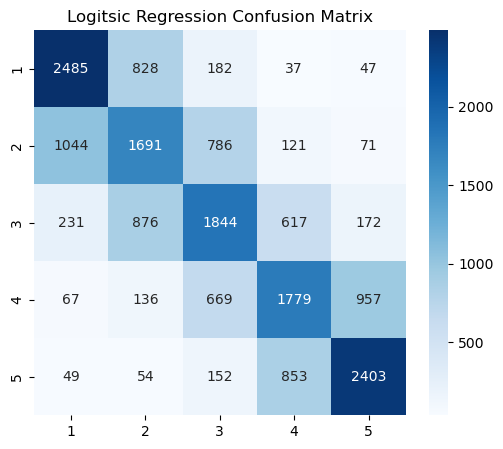

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, logistic_spacy_pred))

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.set_title("Logitsic Regression Confusion Matrix")
sb.heatmap(confusion_matrix(y_test, logistic_spacy_pred),
           annot=True, cmap='Blues', fmt="g", 
           xticklabels=logistic_regression_spacy.classes_,
           yticklabels=logistic_regression_spacy.classes_,
           vmin=0, vmax=2653)

#### 3.3.2 - Random Forest Evaluation

In [ ]:
rnd_forest_spacy_pred = random_forest.predict(X_test_spacy)

              precision    recall  f1-score   support

           1       0.50      0.59      0.54      3579
           2       0.37      0.32      0.34      3713
           3       0.38      0.35      0.37      3740
           4       0.40      0.37      0.38      3608
           5       0.54      0.60      0.57      3511

    accuracy                           0.44     18151
   macro avg       0.44      0.45      0.44     18151
weighted avg       0.44      0.44      0.44     18151



<Axes: title={'center': 'Random Forest Confusion Matrix'}>

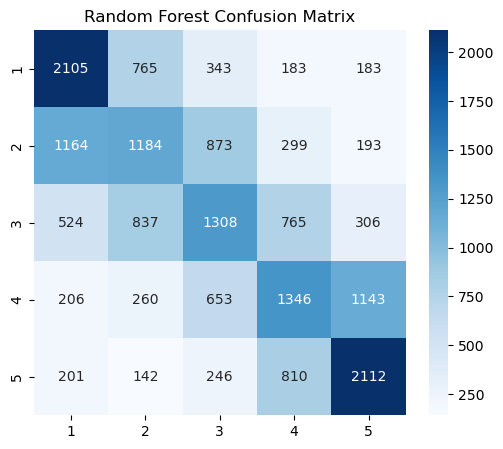

In [ ]:
print(classification_report(y_test, rnd_forest_spacy_pred))

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.set_title("Random Forest Confusion Matrix")
sb.heatmap(confusion_matrix(y_test, rnd_forest_spacy_pred),
           annot=True, cmap='Blues', fmt="g", 
           xticklabels=logistic_regression_spacy.classes_,
           yticklabels=logistic_regression_spacy.classes_,
           vmin=0, vmax=2653)

In [ ]:
print("mean squared error: ")
print("Logistic Regression (tfidf): ", mean_squared_error(y_test, logistic_ngram_pred))
print("Logistic Regression (spacy): ", mean_squared_error(y_test, logistic_spacy_pred))
print("Random Forest: ", mean_squared_error(y_test, rnd_forest_spacy_pred))

print("\nmean absolute error: ")
print("Logistic Regression (tfidf): ", np.abs(logistic_ngram_pred - y_test).mean())
print("Logistic Regression (spacy): ", np.abs(logistic_spacy_pred - y_test).mean())
print("Random Forest: ", np.abs(rnd_forest_spacy_pred - y_test).mean())

mean squared error: 
Logistic Regression (tfidf):  0.631149798909151
Logistic Regression (spacy):  0.7824913227921326
Random Forest:  1.5195856977576994

mean absolute error: 
Logistic Regression (tfidf):  0.47237066828273927
Logistic Regression (spacy):  0.5337997906451435
Random Forest:  0.808440306319211


# Conclusion

Interestingly the tfidf model with the smaller corpus performs better than the spacy model with the large corpus. This might be due to the fact that the features are way more specific in the smaller corpus.  
The logistic regression model with the tfidf-ngrams is the best perfroming model for this task. The random forest model could not outperform it and has lower MAE aswell as accuracy. 

In [ ]:
new_entry1 = pd.DataFrame({
    'name': ['logistic regression spacy'],
    'MAE': [0.534],
    'MSE': [0.782],
    'accuracy': [0.56]
})

new_entry2 = pd.DataFrame({
    'name': ['random forest'],
    'MAE': [0.808],
    'MSE': [1.520],
    'accuracy': [0.44]
})
conclusion_df = pd.concat([conclusion_df, new_entry1, new_entry2], ignore_index=True)
conclusion_df

,name,MAE,MSE,accuracy
0,random,1.598,3.982,NaN
1,all 5s,2.013,6.019,NaN
2,linear regression,0.630,0.630,NaN
3,linear regression (clipped & rounded),0.558,0.685,NaN
4,logistic regression,NaN,NaN,0.59
5,logistic regression,0.471,0.629,0.59
6,linear regression (clipped & rounded),0.558,0.685,0.50
7,logistic regression ngrams,0.428,0.542,0.62
8,linear regression ngrams,1.477,3.724,0.26
9,logistic regression spacy,0.534,0.782,0.56
